Usage examples for keppy
----------------

As the two-syllable name implies, keppy is a simple program designed to do a not very trivial task: simulate radial velocities of a star orbited by a massive object or "reverse engineer" radial velocity measurements to estimate the orbital parameters of the system being studied. The formalism behind it is based on https://arxiv.org/abs/1009.1738. Keep in mind that the code is still in heavy development and there is no documentation at the moment. Additionally, This is code is not "installable" at this point, and thus this notebook has to be run on the same folder as the code itself. keppy requires the following packages: `numpy`, `scipy` and `emcee`. This notebook requires `matplotlib`.

In this notebook, we will walk through the main features of keppy using two exoplanetary systems: HD156846 b and HD83443 b.

Let's start by importing some libraries that we will need:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import orbit
import estimate
import time

Now, let's create the radial velocities for the star HD 156846 due to the gravitational interaction with the planet HD 156846 b. The orbital parameters are: velocity semi-amplitude $K = 0.464$ km/s, orbital period $T = 359.51$ days, time of periapse passage $t_0 = 3998.1$ [JD-2.45E6 days], argument of periapse $\omega = 52.2$ [degrees] and eccentricity $e = 0.847$. The star's proper motion $V_Z = -68.54$ km/s, and we will use $nt = 1000$ points to compute one period (which is kind of arbitrary: feel free to use more or less than that). We will use `log_rvs` from `orbit` in order to work on logarithm space for the parameters that cannot be negative. If you don't want to work on log-space, you can use `get_rvs` instead.

In [2]:
ts = np.linspace(3600., 4200., 1000) # The time window [JD-2.45E6 days]
start_time = time.time() # We use this to measure the computation time
rvs = orbit.log_rvs(log_k=np.log(0.464),
                    log_period=np.log(359.51),
                    t0=3998.1,
                    w=52.2,
                    log_e=np.log(0.847),
                    vz=-68.54,
                    nt=1000,
                    ts=ts)
print('RV calculation took %.4f seconds' % (time.time()-start_time))

RV calculation took 0.0187 seconds


Now, we plot the radial velocities in the time window we specified in the previous box

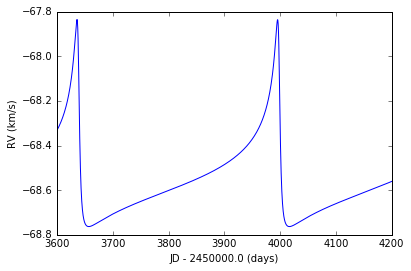

In [3]:
%matplotlib inline
plt.plot(ts, rvs)
plt.xlabel('JD - 2450000.0 (days)')
plt.ylabel('RV (km/s)')
plt.show()

There we go! This exoplanet has a very eccentric orbit, and that is what causes these weird radial velocities variation. For objects with less eccentric orbits (more circular), the radial velocities basically look like a senoid.

Well, that was simple enough. But most of what astronomers do is to measure radial velocities (RV) and then trying to infer the orbital parameters of the system from the RV data. Can keppy help us with that? Yes! First, let's create some mock data for the HD 83443 b exoplanetary system. Previous studies have estimated the orbital parameters to be: velocity semi-amplitude $K = 58.1$ km/s, orbital period $T = 2.98565$ days, time of periapse passage $t_0 = 1497.5$ [JD-2.45E6 days], argument of periapse $\omega = 11$ [degrees] and eccentricity $e = 0.013$, with a proper motion $V_Z = 29.027$ km/s, and we consider these values as *truth*. Let's create the true orbit in a similar fashion that we previously did:

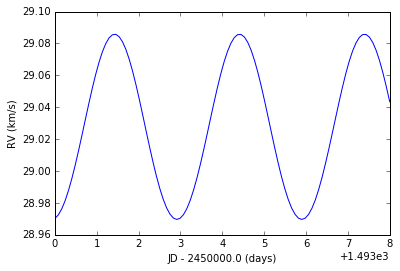

In [4]:
# The "true" parameters
k_true = 0.0581
period_true = 2.98565
t0_true = 1497.5
w_true = 11.0
e_true = 0.013

# Proper motion and number of points to compute a period of RVs
vz=29.027
nt=1000

ts = np.linspace(1493., 1501., 100)
rvs = orbit.log_rvs(log_k=np.log(k_true),
                    log_period=np.log(period_true),
                    t0=t0_true,
                    w=w_true,
                    log_e=np.log(e_true),
                    vz=vz,
                    nt=nt,
                    ts=ts)
plt.plot(ts, rvs)
plt.xlabel('JD - 2450000.0 (days)')
plt.ylabel('RV (km/s)')
plt.show()

And now let's "observe" the data by injecting noise to the points:

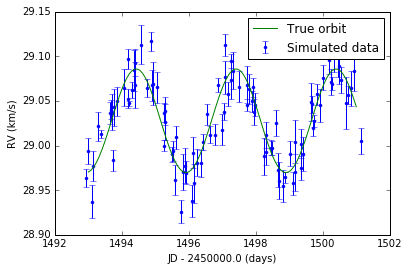

In [5]:
rv_d = np.array([rvk + np.random.normal(loc=0., scale=0.015) for rvk in rvs])
t_d = np.array([tk + np.random.normal(loc=0., scale=0.1) for tk in ts])
rv_derr = np.array([0.015 + np.random.normal(loc=0.0, scale=0.005)
                    for k in rvs])

plt.errorbar(t_d, rv_d, fmt='.', yerr=rv_derr, label="Simulated data")
plt.plot(ts, rvs, label="True orbit")
plt.xlabel('JD - 2450000.0 (days)')
plt.ylabel('RV (km/s)')
plt.legend(numpoints=1)
plt.show()

Okay, now that we have the observation datapoints, let's try to estimate the orbital parameters and see if we can recover their true values from our data. To do that, the most straightforward way with keppy is to use its maximum likelihood estimation routine `ml_orbit`, located inside `estimate`.

We need to provide the routine with a first guess. Since we know the true values of the orbital parameters in the first place, we might as well use them as guess. In practice, we don't know the true values, but we can have an idea just by performing an analysis by eye or something like a periodogram (which provides a first guess for the period, which is probably the most difficult one to estimate by eye).

Then, we run the routine `ml_orbit`. The optional parameters for this function are:
  * `k_interval`: it tunes the upper limit for estimating $K$ (default = 20)
  * `t0_interval`: it tunes the lower and upper limits for estimating $t_0$ (default = 100)
  * `maxiter`: maximum number of iterations for the `scipy.minimize` (default = 200)

In [16]:
guess = [k_true, period_true, t0_true, w_true, e_true]
print('Starting maximum likelihood estimation.')
start_time = time.time()
params_ml = estimate.ml_orbit(t_d, rv_d, rv_derr, guess=guess, vz=vz)
print('Orbital parameters estimation took %.4f seconds' %
      (time.time()-start_time))
print('\nK = %.3f, T = %.2f, t0 = %.1f, w = %.1f, e = %.3f' %
      (params_ml[0], params_ml[1], params_ml[2], params_ml[3],
       params_ml[4]))

Starting maximum likelihood estimation.
Orbital parameters estimation took 0.4306 seconds

K = 0.046, T = 2.91, t0 = 1497.5, w = 11.0, e = 0.013


That hopefully worked quite quickly, since we're working with a well-behaved almost sinusoidal curve of radial velocities. Now, let's compare the estimated orbit with the true one:

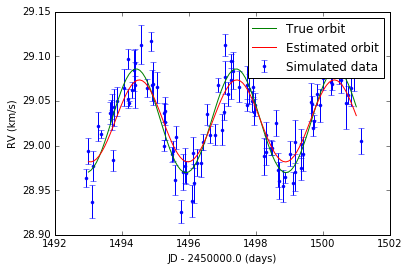

In [18]:
# First we compute the estimated orbit
rv_est = orbit.get_rvs(k=params_ml[0],
                       period=params_ml[1],
                       t0=params_ml[2],
                       w=params_ml[3],
                       e=params_ml[4],
                       vz=vz,
                       nt=nt,
                       ts=ts)

# Plotting the results
plt.errorbar(t_d, rv_d, fmt='.', yerr=rv_derr, label="Simulated data")
plt.plot(ts, rvs, label="True orbit")
plt.plot(ts, rv_est, label="Estimated orbit")
plt.plot()
plt.xlabel('JD - 2450000.0 (days)')
plt.ylabel('RV (km/s)')
plt.legend(numpoints=1)
plt.show()

And there we have it. The only problem now is to know the uncertainties of our estimation. `ml_orbit` calculates the maximum likelihood values, but it does not compute confidence intervals for our estimated parameters. In order to obtain those, we need a more advanced tool: a MCMC (Markov chain Monte Carlo) sampler. In the case of `keppy`, it uses [`emcee`](http://dan.iel.fm/emcee/current/).

Continues in the next version of the notebook...